In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install efficientnet

In [ ]:
# for accessing tabular data
import pandas as pd
import numpy as np
import os
os.chdir('/content/drive/My Drive/')
# adding classweight
from sklearn.utils import class_weight
# Evaluation Metric
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score
# for visualization
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
# backend
import keras
from keras import backend as K
import tensorflow as tf
from keras.callbacks import Callback
# for transfer learning
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.densenet import DenseNet121
from keras.applications.resnet import ResNet50, ResNet152
from keras.applications.inception_v3 import InceptionV3
#from efficientnet.keras import EfficientNetB0, EfficientNetB3, EfficientNetB4
from keras.applications.xception import Xception
# for model architecture
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dropout, Dense, Conv2D, MaxPooling2D, Activation, Flatten
# for Tensorboard visualization
from keras.callbacks import TensorBoard
# for Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.applications.densenet import DenseNet121

In [ ]:
try:
    x_train = np.load("/content/drive/MyDrive/processed_images1/training.npy", mmap_mode=None, allow_pickle=False, fix_imports=True)
    x_validation = np.load("/content/drive/MyDrive/processed_images1/validation.npy",mmap_mode=None, allow_pickle=False, fix_imports=True)
    x_test = np.load("/content/drive/MyDrive/processed_images1/test.npy", mmap_mode = None,allow_pickle = False, fix_imports = True)
    print("Loaded Successfully...\n")
    print(x_train.shape)
    print(x_validation.shape)
    print(x_test.shape)
except:
    print("file not exists")

Loaded Successfully...

(3112, 256, 256, 3)
(550, 256, 256, 3)
(1928, 256, 256, 3)


In [ ]:
train_labels = pd.read_csv('/content/drive/MyDrive/DR-Data-Blindness_Detection/training.csv')
train_labels = train_labels['diagnosis']
validation_labels = pd.read_csv('/content/drive/MyDrive/DR-Data-Blindness_Detection/validation.csv')
validation_labels = validation_labels['diagnosis']
print("Training:",train_labels.shape[0])
print("Validation:",validation_labels.shape[0])

Training: 3112
Validation: 550


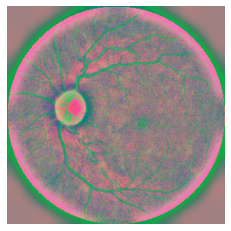

In [ ]:
plt.imshow(x_train[5])
plt.axis('off')
plt.show()

#Transforming Target Labels:

In [ ]:
def ordinal_regression(labels):
    """
    This function is used to create one_hot_encoding of the labels.
    E.x: category = 3 -> one-hot-encoding [1,1,1,1,0].
         category = 2 -> one-hot-encoding [1,1,1,0,0].
    """
    y_train = pd.get_dummies(labels).values
    y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
    y_train_multi[:, 4] = y_train[:, 4]

    for i in range(3, -1, -1):
         y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])
    return y_train_multi
labels_train = ordinal_regression(train_labels)
labels_validation = ordinal_regression(validation_labels)
print(labels_train.shape)
print(labels_validation.shape)
print("Ex: Original Category: {}\n After one_hot_encoding: {}".format(train_labels.iloc[23],labels_train[23]))

(3112, 5)
(550, 5)
Ex: Original Category: 0
 After one_hot_encoding: [1 0 0 0 0]


In [ ]:
#computing class weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes = [0,1,2,3,4],
                                                  y = train_labels)
print(class_weights)

[0.40573664 1.98216561 0.73309776 3.79512195 2.47968127]


#Cohen's Kappa:

In [ ]:
def kappa_metric(y_true, y_pred):
    """
    This function is used for calculating kappa score between the model predicted values and true values
    Args: y_true (np.ndarray or list) - true values
          y_pred (np.ndarray or list) - model predicted value
    Output: _kappa_ (integer or float) - return's kappa score
    """
    y_true = y_true.sum(axis=1) - 1
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(int).sum(axis=1) - 1
    _kappa_ = cohen_kappa_score( y_true, y_pred,  weights='quadratic' )
    return _kappa_

In [ ]:
class Metrics(Callback):
    def __init__(self, path):
        ''' Initialization of variables '''
        super(Callback, self).__init__()
        self.path = path
        self.validation_data = val_data
    def ModelCheckPoint(self, path):
        ''' This function is used for Storing the model weights if val_kappa improves from all the previous epochs'''
        self.model.save(path)
    def on_train_begin(self, logs={}):
        self.val_kappas = []
    def on_epoch_end(self, epoch, val_data, logs={}):
        ''' This function is used for calculating kappa score on each epoch and updates the validation kappa score if it improves from the previous epochs'''
        self.validation_data = val_data
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_val = y_val.sum(axis=1) - 1
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1
        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred,
            weights='quadratic'
        )
        self.val_kappas.append(_val_kappa)
        print(f"\b - val_kappa:  {_val_kappa:.4f}")
        if _val_kappa == max(self.val_kappas):
            print("\n\t\tValidation Kappa has improved. Saving model to {}...".format(self.path))
            self.ModelCheckPoint(self.path)
        else:
            print("\n\t\tValidation kappa did not improved from {}".format(max(self.val_kappas)))
        return

In [ ]:
class Metrics(Callback):
    def __init__(self, path):
        ''' Initialization of variables '''
        super(Callback, self).__init__()
        self.path = path
    def ModelCheckPoint(self, path):
        ''' This function is used for Storing the model weights if val_kappa improves from all the previous epochs'''
        self.model.save(path)
    def on_train_begin(self, logs={}):
        self.val_kappas = []
    def on_epoch_end(self, epoch, logs={}):
        ''' This function is used for calculating kappa score on each epoch and updates the validation kappa score if it improves from the previous epochs'''
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_val = y_val.sum(axis=1) - 1
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1
        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred,
            weights='quadratic'
        )
        self.val_kappas.append(_val_kappa)
        print(f"\b - val_kappa:  {_val_kappa:.4f}")
        if _val_kappa == max(self.val_kappas):
            print("\n\t\tValidation Kappa has improved. Saving model to {}...".format(self.path))
            self.ModelCheckPoint(self.path)
        else:
            print("\n\t\tValidation kappa did not improved from {}".format(max(self.val_kappas)))
        return

In [ ]:
class PerformanceMetric:
    def __init__(self,actual_labels,predicted_labels):
        ''' Initialization of variables '''
        self.actual_labels = actual_labels
        self.predicted_labels = predicted_labels
    def single_value_conversion(self):
        ''' This function is used for Converting model predicted values into single values
           Ex: model_predicted_value: [0,1,0,0,0] and it converts as 1'''
        predicted_labels = self.predicted_labels > 0.5
        prediction_ordinal = np.empty(predicted_labels.shape, dtype = int)
        prediction_ordinal[:,4] = predicted_labels[:,4]
        for i in range(3, -1, -1): prediction_ordinal[:, i] = np.logical_or(predicted_labels[:,i], prediction_ordinal[:,i+1])
        self.predicted_labels = prediction_ordinal.sum(axis = 1)-1
        self.actual_labels = self.actual_labels.sum(axis = 1)-1
    def confusionMatrix(self):
        ''' This function is used for calculating confusion matrix between model predicted values and true values using sklearn implementation.'''
        confusion_matrix_ = confusion_matrix(self.actual_labels, self.predicted_labels)
        return confusion_matrix_
    def precision(self, matrix):
        ''' This function is used for calculating precision matrix between predicted values and true values using confusion matrix'''
        precision_matrix =(((matrix.T)/(matrix.sum(axis=1))).T)
        return precision_matrix
    def recall(self, matrix):
        ''' this function is used for calculating recall matrix between predicted values and true values using confusion matrix'''
        recall_matrix =(matrix/matrix.sum(axis=0))
        return recall_matrix
    def subplot_(self, matrix, i, title):
        ''' This function is used for subplots'''
        plt.subplot(1,3,i)
        labels = [1,2,3,4,5]
        sns.heatmap(matrix, annot=True, cmap=sns.light_palette('green'),linewidths = 0.8,cbar = False, fmt=".3f", xticklabels=labels, yticklabels=labels)
        plt.title(title)
        plt.xlabel('Predicted Class Labels')
        plt.ylabel('Actual Class Labels')
    def plotting(self):
        """
        This function is used for calculating number of misclassified points, confusion, recall and precision matrixes and plotting it using subplots.
        """
        self.single_value_conversion()
        confusion_matrix = self.confusionMatrix()
        #print("Number of misclassified points: ",(len(self.actual_labels)-np.trace(confusion_matrix))/len(self.actual_labels)*100,"\n")
        precision_matrix = self.precision(confusion_matrix)
        recall_matrix = self.recall(confusion_matrix)
        plt.figure(figsize=(20,5))
        self.subplot_(confusion_matrix, 1, 'Confusion Matrix')
        self.subplot_(precision_matrix, 2, 'Precision')
        self.subplot_(recall_matrix, 3, 'Recall')
        plt.show()

In [ ]:
def plotting(iter, val_kappa):
    """
    This function is used for plotting validation_kappa on each epoch
    Args: iter(integer) - Number of epochs we runned on model training.
          val_kappa(list) - validation kappa score on each epoch
    Output: None - It doesn't return anything.
    """
    epoch = [i for i in range(iter)]
    plt.plot(epoch,val_kappa)
    plt.title('validation_kappa on each epoch')
    plt.xlabel('epoch')
    plt.ylabel('val_kappa')
    plt.grid()
    plt.show()
def test_prediction(predicted_labels):
    '''
    Making predictions of the probability scores. The class with more score will be taken as predicted class.
    Arguments:
    predicted_labels - (np.array) - probability score of given sample
    '''
    predicted_labels = predicted_labels > 0.5
    prediction_ordinal = np.empty(predicted_labels.shape, dtype = int)
    prediction_ordinal[:,4] = predicted_labels[:,4]
    for i in range(3, -1, -1): prediction_ordinal[:, i] = np.logical_or(predicted_labels[:,i], prediction_ordinal[:,i+1])
    predicted_labels = prediction_ordinal.sum(axis = 1)-1
    return predicted_labels

#Data Augmentation with modeling

In [ ]:
def GAP2D():
    '''Global average pooling layer'''
    global_average_pooling = GlobalAveragePooling2D()
    return global_average_pooling
def dropout(value = 0.5):
    '''Dropout layer'''
    dropout_layer = Dropout(value)
    return dropout_layer
def dense():
    '''Dense layer'''
    dense_layer = Dense(5, activation='sigmoid')
    return dense_layer

In [ ]:
global_average_pooling_layer = GAP2D()
dropout_layer = dropout()
dense_layer = dense()

##vgg16

In [ ]:
def VGG16_(top_6 = False):
    '''This function is used for building a model architecture of pretrained vgg16 on imagenet data set.'''
    vgg = VGG16(weights = 'imagenet', include_top = False, input_shape = (256,256,3))
    if not top_6:
        for layer in vgg.layers:
            layer.trainable = False
    else:
         for layer in vgg.layers[:13]:
            layer.trainable=False
    x = global_average_pooling_layer(vgg.layers[-1].output)
    x = dropout_layer(x)
    output = dense_layer(x)
    model = Model(vgg.layers[0].input,output)
    model.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(lr=0.00005), metrics=['accuracy'])
    return model

In [ ]:
vgg16 = VGG16_(True)
vgg16.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# create callbacks list
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)

epochs = 30; batch_size = 32
checkpoint = ModelCheckpoint('../working/densenet_.h5', monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4,
                                   verbose=1, mode='auto', epsilon=0.0001)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=9)

csv_logger = CSVLogger(filename='../working/training_log.csv',
                       separator=',',
                       append=True)


In [ ]:
from keras.callbacks import Callback
class Metrics(Callback):
    def __init__(self, validation_data=(), batch_size=64, interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.batch_size = batch_size
        self.valid_generator, self.y_val = validation_data
        self.history = []

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict_generator(generator=self.valid_generator,
                                                  steps=np.ceil(float(len(self.y_val)) / float(self.batch_size)),
                                                  workers=1, use_multiprocessing=False,
                                                  verbose=1)
            def flatten(y):
                return np.argmax(y, axis=1).reshape(-1)

            score = cohen_kappa_score(flatten(self.y_val),
                                      flatten(y_pred),
                                      labels=[0,1,2,3,4],
                                      weights='quadratic')
            print("\n epoch: %d - QWK_score: %.6f \n" % (epoch+1, score))
            self.history.append(score)
            if score >= max(self.history):
                print('saving checkpoint: ', score)
                self.model.save('/content/Vgg16_model.h5')

qwk = Metrics(validation_data=(x_validation, labels_validation),
                    batch_size=12, interval=1)

In [ ]:
#tensorboard = TensorBoard(log_dir = '/content/drive/My Drive/vgg16')
#kappa_metrics = Metrics('/content/drive/My Drive/models/vgg16.h5')
#callbacks_list = [checkpoint, csv_logger, reduceLROnPlat, early, qwk]
data_generator = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=180,zoom_range = 0.2)
vgg16 = VGG16_(top_6 = True)
history = vgg16.fit(
                   data_generator.flow(x_train, labels_train, batch_size=12),
                    steps_per_epoch=len(x_train) / 12,
                    epochs=1,
                    initial_epoch=0,
                    verbose=1,
                    validation_data=(x_validation, labels_validation),
                    validation_steps=len(x_validation) / 12,
                    callbacks= [qwk])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


260/259 [==============================] - ETA: -6s - loss: 0.3007 - accuracy: 0.9380

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


46/46 [==============================] - 319s 7s/step

 epoch: 1 - QWK_score: 0.000000 

saving checkpoint:  0.0
259/259 [==============================] - 3259s 13s/step - loss: 0.3007 - accuracy: 0.9380 - val_loss: 0.2007 - val_accuracy: 0.9982


In [ ]:
vgg16 = VGG16_(top_6 = True)
vgg16.load_weights("/content/Vgg16_model.h5")
result = vgg16.evaluate(x_validation,labels_validation)
y_pred = vgg16.predict(x_validation)
print("After running the model for 1 epochs we got loss = {} Accuracy = {} kappa_score = {} on validation data".format(np.round(result[0],4),np.round(result[1],4),np.round(kappa_metric(labels_validation,y_pred),4)))


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


18/18 [==============================] - 322s 18s/step - loss: 0.2007 - accuracy: 0.9982
After running the model for 1 epochs we got loss = 0.2007 Accuracy = 0.9982 kappa_score = 0.7623 on validation data


In [ ]:
ytrain_vgg16 = vgg16.predict(x_train)
ytrain_vgg16 = test_prediction(ytrain_vgg16)
print("First five data points predictions in training:",ytrain_vgg16[:5])
print("length of traindata prediction:",ytrain_vgg16.shape,"\n")

yvalidation_vgg16 = vgg16.predict(x_validation)
yvalidation_vgg16 = test_prediction(yvalidation_vgg16)
print("First five data points predictions in validation:",yvalidation_vgg16[:5])
print("length of validation data prediction:",yvalidation_vgg16.shape,"\n")

ytest_vgg16 = vgg16.predict(x_test)
ytest_vgg16 = test_prediction(ytest_vgg16)
print("First five data points predictions in test:",ytest_vgg16[:5])
print("length of test data prediction:",ytest_vgg16.shape)

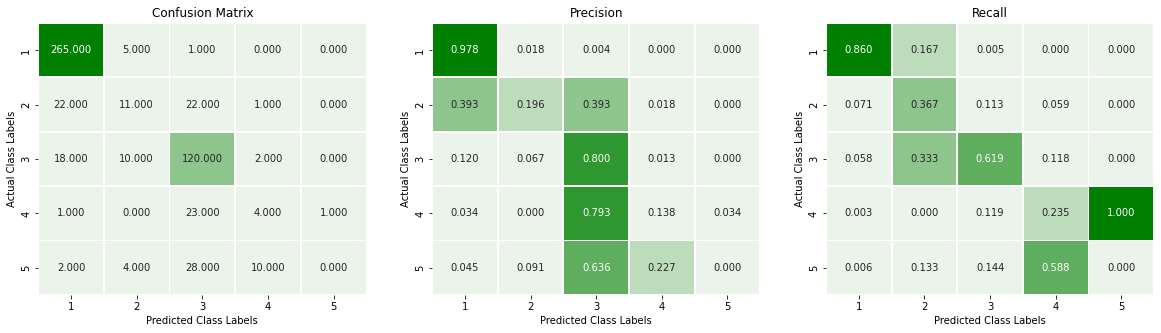

In [ ]:
metric = PerformanceMetric(labels_validation, y_pred)
metric.plotting()

#Interpretability

In [ ]:
### initialization
img_width = 256
img_height = 256
no_channels = 3

In [ ]:
def draw_circle(img):

    '''
    This function is used for drawing a circle from the center of the image.
    Arguments: img(np.array) - image for which we need to draw a circle.
    '''

    x = int(img_width/2)
    y = int(img_height/2)
    r = np.amin((x,y))     # finding radius to draw a circle from the center of the image
    circle_img = np.zeros((img_height, img_width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    return img

In [ ]:
def test_prediction(predicted_labels):
    '''
    Making predictions of the probability scores. The class with more score will be taken as predicted class.
    Arguments:
    predicted_labels - (np.array) - probability score of given sample
    '''
    predicted_labels = predicted_labels > 0.5
    prediction_ordinal = np.empty(predicted_labels.shape, dtype = int)
    prediction_ordinal[:,4] = predicted_labels[:,4]
    for i in range(3, -1, -1): prediction_ordinal[:, i] = np.logical_or(predicted_labels[:,i], prediction_ordinal[:,i+1])
    predicted_labels = prediction_ordinal.sum(axis = 1)-1
    return predicted_labels

In [ ]:
def VGG16_():
    '''This function is used for building a model architecture of pretrained vgg16 on imagenet data set.'''
    vgg = VGG16(weights = 'imagenet', include_top = False, input_shape = (256,256,3))
    x = global_average_pooling_layer(vgg.layers[-1].output)
    x = dropout_layer(x)
    output = dense_layer(x)
    model = Model(vgg.layers[0].input,output)
    model.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(lr=0.00005), metrics=['accuracy'])
    return model
vgg = VGG16_()
vgg.load_weights("/content/Vgg16_model.h5")

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#Grad-Cam

In [ ]:
def plot_gradient_heatmap(model, img, layer_name = 'last_conv_layer'):
    '''
    This function is used to plot the gradients for model interpretability.
    Reference and code credits: http://www.hackevolve.com/where-cnn-is-looking-grad-cam/
    Arguments:
    model - trained model
    img - (np.array) - image data
    layer_name - (string) - layer from which we need to take gradients
    '''
    # model predictions
    preds = model.predict(img[np.newaxis])   # vgg model
    preds = preds>0.5
    class_idx = (preds.astype(int).sum(axis=1)-1)[0]
    class_output_tensor = model.output[:,class_idx]

    # taking the output at particular convolutional layer
    layer_output = model.get_layer(layer_name)

    # taking gradients from model
    with tf.GradientTape() as tape:
        grads = model.predict(class_output_tensor, layer_output)[0]
    grads = tape.gradient(grads)[0]
    pooled_grads = K.mean(grads,axis=(0,1,2))
    iterate = K.function([model.input],[pooled_grads, layer_output.output[0]])
    pooled_grads, layer_output = iterate([img[np.newaxis]])
    for i in range(pooled_grads.shape[0]):
        layer_output[:,:,i] *= pooled_grads[i]

    # plotting heatmap
    heatmap = np.mean(layer_ouput, axis=-1)
    heatmap = np.maximum(heatmap,0)
    heatmap /= np.max(heatmap)     # normalizing the heatmap
    heatmap=cv2.resize(heatmap,(viz_img.shape[1],viz_img.shape[0]))  # resizing the image
    heatmap_color = cv2.applyColorMap(np.uint8(heatmap*255), cv2.COLORMAP_SPRING)/255
    heated_img = heatmap_color*0.5 + viz_img*0.5
    return heated_img

In [ ]:
def plot_interpretability(data,label):
    '''
    this function is used to plot the original, preprocessed image and gradients using grad-cam's
    Arguments:
    data - (np.array) - Image data
    label - (integer) - target class label
    '''
    def plot(row,col,index,img,title=None):
        ''' plotting individual images '''
        plt.subplot(row,col,index)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    count=0
    for i in range(3):   ### for each row (3 here)
        iter=0
        fig=plt.figure(figsize=(20,5))
        for j in range(2):   ### for each column (2 here)
            img = data[count]  ### image data
            plot(1,6,iter+1,img)  ### plotting original image
            iter+=1
            img_ = np.expand_dims(img,axis=0)
            pred = vgg.predict(img_)      ### predicting class label using densenet
            pred = test_prediction(pred)
            plot(1,6,iter+1,img,'Target Class: '+str(label))   ### plotting preprocessed image
            iter+=1
            img = plot_gradient_heatmap(vgg,img)
            img = draw_circle(img)            ### drawing circle for better visualization
            plot(1,6,iter+1,img,'Predicted Class: '+str(pred))    ### plotting gradient plot
            iter+=1
            count+=1

In [ ]:
N = 6
data = []
for i in range(len(validation_labels)):
    if validation_labels[i]==0: data.append(x_validation[i])
plot_interpretability(x_validation[:N],0)